In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as nprm
import pandas as pd
import networkx as nx
import shelve as sl
import seaborn as sns
import scipy as sp


import EpiKit as epi
import covid_model as covid

# Demostration notebook

In this notebook we implement the simulation of a COVID agent model.
First we define two dictionaries with the values of different parameters. `ParamSim` contains parameters for the preparation of the simulation in general, and `ParamTest` contains parameters for the testing protocols.


In [2]:

ParamSim = {'R0': 3.0,
            'generation':1,
            'tmax': 60,
            'protocol': 'ST',
            'imm': 0,
            'weekdays':2,
            'E(t=0)': 1,
            'vax': '93p',
            'rvax': 0,
            'vax_selection': True,
            'weekden': 2,
            'net': 'DYN',
            'r_period': 1.0,
            }

ParamTest = {'W': 7,
             'Ntw': 5,
             'adhesion' : 0.5,
             'adhesion_decay':'1.0',
             'Delta_R' : 1,
             'Delta_Q' : 7.0,
             'type' :  'auto',
             'p_detect': np.array([0.5, 0.5])}


beta = covid.beta_from_R0(ParamSim['R0'], 'office', 
                        ParamSim['net'], ParamSim['r_period'], 
                        ParamSim['weekdays'], ParamSim['generation'])

We read the networks and create the object Graph that we will use to obtain interactions and time of activity in the simulation.

In [3]:
# reading networks
network_folder = 'Networks/office/'
dataset_file_dict = {'CMD': network_folder + 'daily_CMD.json.gzip',
                      'CMB': network_folder + 'daily_CMB.json.gzip',
                      'CMD1': network_folder + 'daily_CMD.json.gzip',
                      'CMB1': network_folder + 'daily_CMB.json.gzip',
                      'HET': network_folder + 'daily_HET.json.gzip',
                      'HOM': network_folder + 'daily_HOM.json.gzip',
                      'dHET': network_folder + 'daily_dHET.json.gzip',
                      'DYN': network_folder + 'temporal_DYN.json.gzip',
                      'dCM': network_folder + 'matrix_dCM.json.gzip',
                      'CM': network_folder + 'matrix_CM.json.gzip',
                      'FULL': network_folder + 'matrix_FULL.json.gzip',
                      }    
Gt,contact_meta,_ , net_type = epi.load_json_dataset(dataset_file_dict[ParamSim['net']] )
TeachersDict = {}
dt_G = 900

ParamSim['Npop'] = contact_meta.shape[0]
ParamTest['Npop'] = contact_meta.shape[0]

net_cycle = max([ round(len(Gt)*7/5),7])
gdic = {'Gt' : Gt,
            'dt_sec' : dt_G,
            'sec0': int(8*3600),
            'secf': int(12*3600),
            'meta' : contact_meta,
            'TeachersDict': TeachersDict,
            'net_cycle': net_cycle,
            'type': net_type,
            }

Graphs = epi.GraphDataOffice(gdic)


In the file `covid_model` we defined the paramers for a specific version of a compartmental model to model COVID. We imported and we create an AgentModel object which integrates its with the graphs


In [6]:
S = covid.S
Param, React, S_inf, S_dict = covid.get_disease_model(beta,ParamSim,'office')

Model = epi.AgentModel(Graphs, Param, React,
                   S, S_inf, S_dict, 
                   N=ParamSim['Npop'],
                   tmax = ParamSim['tmax'])

if ParamSim['net'] in ['CMD','CMB']:
    Model.Nodes.set_shuffle(True)

elif ParamSim['net'] in ['CMD1','CMB1']:
    Model.Nodes.set_shuffle(True)
    Model.Nodes.Graphs.ndays = 1

if ParamSim['vax_selection']:
    Model.vax_selection = True

We define the function that creates the initial state of the system

In [7]:
def set_condition(Model,ParamSim):
    """
    Function to prepare the initial condition of states for the nodes.
    :param Model: AgentModel object with the simulation
    :param ParamSim: dictionary with the parameters
    :return:
       An numpy array with the initial state for each node
    """
    # choose vaccinated
    if ParamSim['rvax'] > 0:
        Model.Nodes.biogroup = 0*Model.Nodes.ind_nodes
        nodes = Model.Nodes.ind_nodes[  ( Model.Nodes.state!='E') ]
        Nvax = round(  ParamSim['Npop'] * ParamSim['rvax'] )
        Model.Nodes.biogroup[ nprm.choice(nodes,   Nvax, replace=False) ] = np.zeros( Nvax ) + 1

    ind_nodes = np.arange(Model.N)

    # choose recovered
    NR = round( ParamSim['imm'] * ParamSim['Npop'] )
    nodes = np.array(['S' for i in range(Model.N)],dtype='<U4')
    ages = Model.Nodes.biogroup

    ind_R = nprm.choice(ind_nodes[nodes=='S'],  NR, replace=False )
    nodes[ind_R] = 'R'

    # choose seed
    nodes_to_chose = ind_nodes[ (nodes=='S') & (ages==0) ]
    prob = np.array([ Model.Nodes.sigma[i] for i in ages] )
    prob = prob[nodes_to_chose]
    prob = prob/prob.sum()
    ind_E = nprm.choice( nodes_to_chose  )
    nodes[ind_E] = 'E'

    return nodes
set_conditionP = lambda Model: set_condition(Model, ParamSim)

We assign the test object we want to use in the simulation

In [8]:
TestDict = {'NoTest': epi.Test_None,
            'ST' :    epi.Test_ST_office,
            'Reg' :   epi.Test_Regular_office,
            'TW' :    epi.Test_TW_office,
            'TW2tw' :    epi.Test_TW_office_2tw,
            'STRS' :    epi.Test_STRS_office,
            'RegTW' :   epi.Test_RegTW_office,
            }

Test = TestDict['ST'](ParamTest)
Model.set_test_protocol(Test)

# starting time on t0 = 0. Otherwise, the simulation initial time is between 0 and net_cycle
Model.Nodes.Graphs.net_cycle = 0

Finally, we can run a single simulation. and plot the evolution of its states

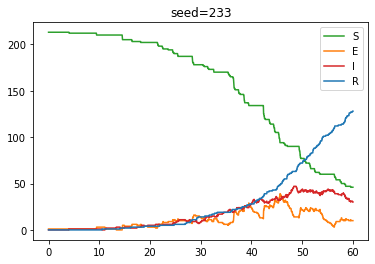

In [9]:
# use a random seed each time
seed = nprm.randint(1000)
nprm.seed(seed)                
                
result = Model.solve( set_condition=set_conditionP, jump_hours=0.25)

                
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

plt.sca(axs)
result.plot_t()
plt.title("seed={}".format( seed))

plt.show()